In [1]:
import matplotlib
print(matplotlib.__version__)

3.6.2


In [2]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import tikzplotlib
from time import time
from genA import genA
from plotA import plotA
from IGP import IGP
from findIdx import findIdx, findNear
from simTraj import *
from train import *

# Set a fixed seed
SEED = 42

# NumPy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU


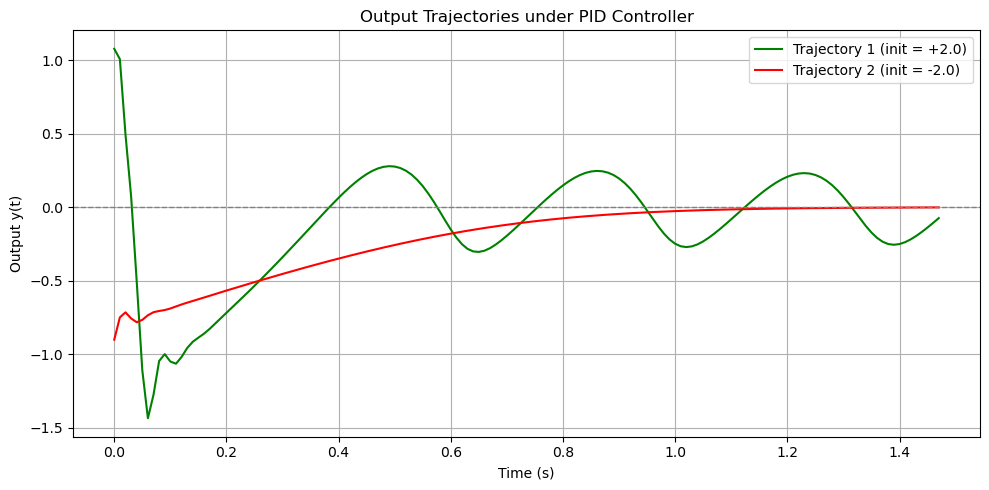

XI1 shape: (148, 4)
XI2 shape: (148, 4)
XI combined shape: (296, 4)
U1 shape: (148,)
U2 shape: (148,)
U combined shape: (296,)
Control input range: min=-0.09, max=0.36
Final outputs: traj1[-1]=-0.075, traj2[-1]=-0.002


In [3]:
# --- NARX System Definition ---
def polynomial_narx(y_k, y_km1, u_km1, u_k):
    a1, a2 = 1, -0.5
    b1 = 0.5
    c = 1
    y_next = a1 * np.sin(y_k) + a2 * np.cos(y_km1) + b1 * u_km1 +  c * u_k
    return y_next

# --- Simulation Parameters ---
timesteps = 150
dt = 0.01

# --- Run Two Trajectories with Different Initial Conditions ---
y_init1 = [2.0, 2.0]
u_init1 = [0.0]
traj1, XI1, U1 = simulate_trajectory_pid(y_init1, u_init1, polynomial_narx,timesteps, dt, noise=0, Kp=0, Ki=2, Kd=0)

y_init2 = [-1.0, -1.0]
u_init2 = [0.0]
traj2, XI2, U2 = simulate_trajectory_pid(y_init2, u_init2, polynomial_narx, timesteps, dt, noise=0, Kp=0.2, Ki=1, Kd=0)

# --- Combine Data ---
XI = np.vstack((XI1, XI2))
U = np.hstack((U1, U2))

# --- Plot Output Trajectories ---
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(traj1)) * dt, traj1, 'g-', label='Trajectory 1 (init = +2.0)')
plt.plot(np.arange(len(traj2)) * dt, traj2, 'r-', label='Trajectory 2 (init = -2.0)')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Output y(t)')
plt.title('Output Trajectories under PID Controller')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Print Control Statistics ---
print("XI1 shape:", XI1.shape)
print("XI2 shape:", XI2.shape)
print("XI combined shape:", XI.shape)
print("U1 shape:", U1.shape)
print("U2 shape:", U2.shape)
print("U combined shape:", U.shape)
print(f"Control input range: min={U.min():.2f}, max={U.max():.2f}")
print(f"Final outputs: traj1[-1]={traj1[-1]:.3f}, traj2[-1]={traj2[-1]:.3f}")


In [4]:
train_x = torch.from_numpy(XI).float()
train_y = torch.from_numpy(U).float()

model, likelihood = trainGPmdl(train_x, train_y)
rkhs_norm = compute_rkhs_norm(model, train_x, train_y)
print(f"RKHS norm of posterior mean: {rkhs_norm:.4f}")

# Evaluation mode
model.eval()
likelihood.eval()

# Make predictions on training data (can predict on new test_x too)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = model(train_x)
    u_pred = preds.mean
    max_error = torch.max(torch.abs(u_pred - train_y)).item()

print(f"Maximum absolute prediction error on training data: {max_error:.4f}")



Iter 1/1000 - Loss: 0.770
Iter 101/1000 - Loss: 0.210
Iter 201/1000 - Loss: -0.533
Iter 301/1000 - Loss: -1.319
Iter 401/1000 - Loss: -2.086
Iter 501/1000 - Loss: -2.766
Iter 601/1000 - Loss: -3.223
Iter 701/1000 - Loss: -3.417
Iter 801/1000 - Loss: -3.460
Iter 901/1000 - Loss: -3.487
Iter 1000/1000 - Loss: -3.483
RKHS norm of posterior mean: 5.1658
Maximum absolute prediction error on training data: 0.0145


c:\Users\YeongjunJang\anaconda3\envs\oPgigp\lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Lengthscale: 5.022045612335205
Outputscale: 7.596725940704346
Gamma: 5.682341575622559


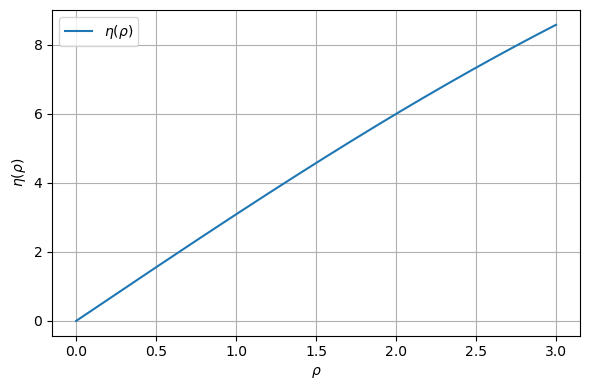

tensor(3.1186)


In [5]:
Gamma = 1.1*rkhs_norm
# Lengthscale of the RBF kernel
lengthscale = model.covar_module.base_kernel.lengthscale.detach().item()

# Outputscale (variance) of the GP
outputscale = model.covar_module.outputscale.detach().item()

# Noise variance (if GaussianLikelihood is used)
noise_variance = likelihood.noise.detach().cpu().numpy()

print(f"Lengthscale: {lengthscale}")
print(f"Outputscale: {outputscale}")
print(f"Gamma: {Gamma}")


def eta_rho(rho, outputscale, lengthscale, Gamma):
    """
    Computes eta(rho) = sigma_f - (k(rho)^2) / sigma_f
    where k(rho) = sigma_f * exp(-0.5 * (rho / lengthscale)^2)
    """
    exp_term = torch.exp(- (rho / lengthscale)**2)
    return Gamma*torch.sqrt(outputscale * (1 - exp_term))


# Define rho values
rho = torch.linspace(0, 3, 1000)

# Compute eta(rho)
eta_vals = eta_rho(rho, outputscale, lengthscale, Gamma)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(rho.numpy(), eta_vals.numpy(), label=r'$\eta(\rho)$')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\eta(\rho)$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

m = (Gamma * (outputscale ** 0.5)) / lengthscale
print(m)

### Integrating PGIGP framework

### Multiple A_delta^k

In [6]:
# Non-conservative approximation
def gammaInv(eps):
    return  eps /7.1186

# Parameters
# delta_list = np.array([0.1])
delta_list = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.8,1,1.5,2,3])  
kbar = 20                        # Iteration depth
y_goal = 0.0

# Generate uncertainty sets A for each delta
A_all = {}  # Or use a list if you don't need to associate with delta

for delta in delta_list:
    A = genA(delta, XI, U, kbar, y_goal, gammaInv)
    A_all[delta] = A  # Store the result keyed by delta


In [7]:
ZETA     = XI[:-1, 1:4]
curr_state1 = np.array([y_init1[0], y_init1[1], u_init1[0]])
curr_state2 = np.array([y_init2[0], y_init2[1], u_init2[0]])
# curr_state3 = np.array([(y_init1[0]+y_init2[0])/2, (y_init1[1]+y_init2[1])/2, (u_init1[0]+u_init2[0])/2])
curr_state3 = np.array([1, 1, 0])


trajectory_sim1, states_visited1 = simulate_trajectory(polynomial_narx, curr_state1, A_all, XI, ZETA, model, likelihood, timesteps)

trajectory_sim2, states_visited2 = simulate_trajectory(polynomial_narx, curr_state2, A_all, XI, ZETA, model, likelihood, timesteps)

trajectory_sim3, states_visited3 = simulate_trajectory(polynomial_narx, curr_state3, A_all, XI, ZETA, model, likelihood, timesteps)


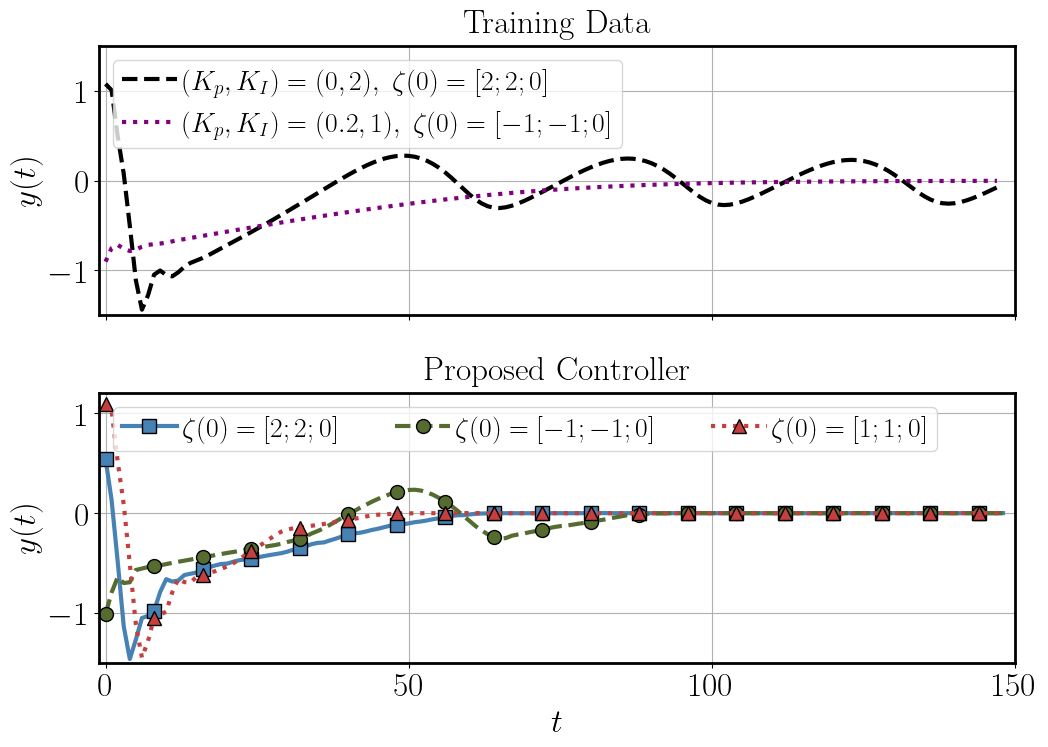

In [13]:
plt.rcParams.update({
    "text.usetex": True,           # Use LaTeX to render text
    "font.family": "serif",        # Match LaTeX serif font (Computer Modern)
    "pgf.rcfonts": False,           # Don't override LaTeX font config
    "font.size": 24,
})


fig, axs = plt.subplots(2, 1, figsize=(11, 8), sharex=True)

# --- Top subplot: Training data ---
axs[0].plot(np.arange(len(traj1)), traj1, linestyle='--', color='black', linewidth=3, label='$(K_p,K_I)=(0,2),~\zeta(0)=[2;2;0]$', alpha=1)
axs[0].plot(np.arange(len(traj2)), traj2, linestyle=':', color='purple', linewidth=3, label='$(K_p,K_I)=(0.2,1),~\zeta(0)=[-1;-1;0]$', alpha=1)

axs[0].set_ylabel('$y(t)$')
axs[0].legend()
axs[0].grid(True)
axs[0].set_xlim(0, 150)
axs[0].set_ylim(-1.5, 1.5)

axs[0].set_xticks([0, 50, 100, 150, 200, 250])
axs[0].set_yticks([-1, 0, 1])
axs[0].legend(loc='upper left', ncol=1, borderpad=0.3,handletextpad=0.2,  prop={'family': 'serif','size': 20})

# --- Bottom subplot: Test simulations ---
axs[1].plot(np.arange(len(trajectory_sim1)), trajectory_sim3, linestyle='-', 
            marker='s', markersize=10, markevery=(0,8), markeredgecolor='black', color='#4682B4', linewidth=3, label='$\zeta(0)=[2;2;0]$')
axs[1].plot(np.arange(len(trajectory_sim2)), trajectory_sim2, linestyle='--', 
            marker='o', markersize=10, markevery=(0,8), markeredgecolor='black', color='#556B2F', linewidth=3, label='$\zeta(0)=[-1;-1;0]$')
axs[1].plot(np.arange(len(trajectory_sim3)), trajectory_sim1, linestyle=':', 
            marker='^', markersize=10, markevery=(0,8), markeredgecolor='black', color="#C63F3F", linewidth=3, label='$\zeta(0)=[1;1;0]$')


axs[1].set_xlabel('$t$')
axs[1].set_ylabel(' $y(t)$')
axs[1].legend(loc='upper left', ncol=3, borderpad=0.3,handletextpad=0.2,  prop={'family': 'serif','size': 20})
axs[1].grid(True)
axs[1].set_xlim(-1, 150)
axs[1].set_ylim(-1.5, 1.2)
axs[1].set_yticks([-1, 0, 1])

axs[0].set_title('Training Data', fontsize=24,fontdict={'family': 'serif', 'weight': 'bold'},pad=10)
axs[1].set_title('Proposed Controller', fontsize=24,fontdict={'family': 'serif', 'weight': 'bold'},pad=10)



for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Adjust thickness here

plt.tight_layout()
plt.savefig("output.pdf")
plt.show()

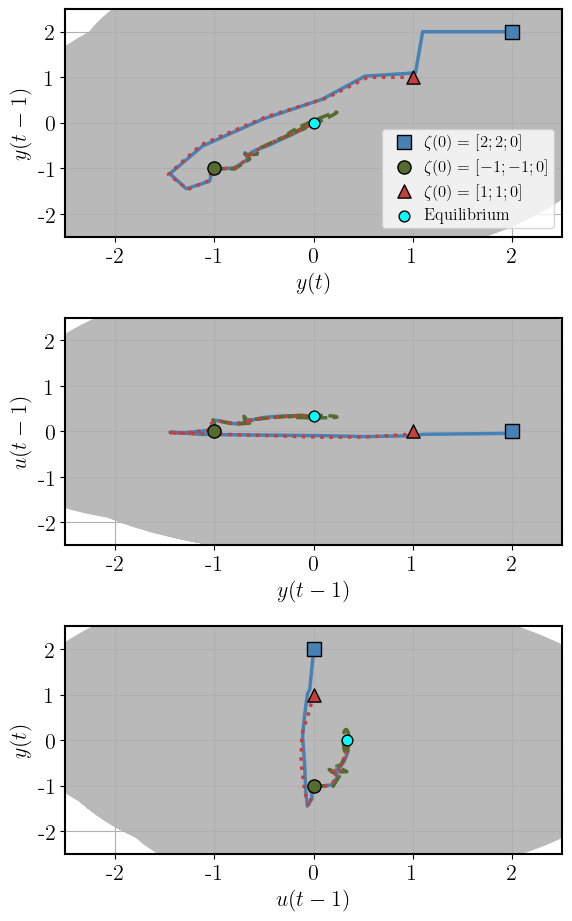

In [14]:
import matplotlib.patches as patches
from matplotlib.patches import CirclePolygon
from matplotlib.collections import PatchCollection
import matplotlib.ticker as mticker

plt.rcParams.update({
    "text.usetex": True,           # Use LaTeX to render text
    "font.family": "serif",        # Match LaTeX serif font (Computer Modern)
    "pgf.rcfonts": False,           # Don't override LaTeX font config
    "font.size": 16,
})


# plotA(A_all, XI, delta_list, kbar, states_visited)
projections = [
        (1, 2),  # y(t) vs y(t-1)
        (2, 3),  # y(t-1) vs u(t-1)
        (3, 1)   # u(t-1) vs y(t)
    ]

axis_labels = {
    0: r'$y(t+1)$',
    1: r'$y(t)$',
    2: r'$y(t-1)$',
    3: r'$u(t-1)$'
}


eq_point = np.array([0.0, 0.0, 1/3])  # example values

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  # Adjust thickness here


trajectory_colors = ['#4682B4', '#556B2F', "#C63F3F"]  # colors for states_visited1, 2, 3
trajectory_labels = ['$\zeta(0)=[2;2;0]$', '$\zeta(0)=[-1;-1;0]$', '$\zeta(0)=[1;1;0]$']
trajectory_markers = ['s', 'o', '^']
trajectory_linestlyes = ['-', '--', ':']

for i, (ax, (dim_x, dim_y)) in enumerate(zip(axs, projections)):
    ax.set_xlabel(axis_labels[dim_x])
    ax.set_ylabel(axis_labels[dim_y])

    ax.set_xlim(-2.5,2.5)
    ax.set_ylim(-2.5,2.5)
    ax.tick_params(axis='both', which='major')
    ax.set_xticks([-2,-1, 0, 1,2])
    ax.set_yticks([-2,-1, 0, 1,2])
    ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%g'))
    
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%g'))
    ax.grid(True)

    # Plot circles as before
    for delta in delta_list:
        A = A_all[delta]
        drawn_circles = []
        circles_to_draw = []

        for k in range(min(len(A), kbar + 1)):
            indices = A[k]['i']
            ris = A[k]['ri']
            if len(indices) == 0:
                continue
            points = XI[indices][:, [dim_x, dim_y]]

            for center, r in zip(points, ris):
                inside_any = False
                for c_center, c_r in drawn_circles:
                    dist = np.linalg.norm(center - c_center)
                    if dist + r <= c_r:
                        inside_any = True
                        break
                if not inside_any:
                    circles_to_draw.append(patches.Circle(center, radius=r))
                    drawn_circles.append((center, r))

        collection = PatchCollection(circles_to_draw,
                                    facecolor="#B9B9B9",
                                    edgecolor="#B9B9B9",
                                    alpha=1,
                                    linewidths=1)
        ax.add_collection(collection)

    # Plot all three trajectories
    for states_visited, t_color, t_label, t_marker, t_linestyle in zip(
        [states_visited1, states_visited2, states_visited3], 
        trajectory_colors, trajectory_labels, trajectory_markers, trajectory_linestlyes):

        states_proj_x = states_visited[:, dim_x - 1]
        states_proj_y = states_visited[:, dim_y - 1]
        ax.plot(states_proj_x, states_proj_y, linestyle=t_linestyle,  color=t_color, linewidth=2.5)
        # Mark initial point
        init_x = states_proj_x[0]
        init_y = states_proj_y[0]
        ax.scatter(init_x, init_y, color=t_color, marker=t_marker, s=90, edgecolor='black', label=f'{t_label}', zorder=5)

    # Plot equilibrium point once
    eq_x = eq_point[dim_x - 1]
    eq_y = eq_point[dim_y - 1]
    ax.scatter(eq_x, eq_y, color=(0, 1, 1), marker='o', edgecolor='black', s=60, label='Equilibrium', zorder=6)

    if i == 0:
        ax.legend(loc='lower right', ncol=1, borderpad=0.3, handletextpad=0.2, prop={'family': 'serif', 'size': 12})

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("traj.pdf")
plt.show()